In [1]:
from keras import layers,models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
#import adanet
import tensorflow as tf
import catboost

/home/ubuntu/anaconda3/envs/hamza/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# recursive elimination of features ! to be checked later 
'''sklearn.feature_selection.RFECV'''

'sklearn.feature_selection.RFECV'

In [3]:
data=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
full=pd.concat([data,test])
full.shape

(1309, 12)

In [4]:
res=full[full['Survived'].isnull()]
res.shape

(418, 12)

In [5]:
full.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
417,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [6]:
full.drop(columns=['Cabin','PassengerId','Ticket'],inplace=True)
full['FamilySize']=full['Parch']+full['SibSp']+1
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,2
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,1


In [7]:
full.isnull().sum()

Age           263
Embarked        2
Fare            1
Name            0
Parch           0
Pclass          0
Sex             0
SibSp           0
Survived      418
FamilySize      0
dtype: int64

In [8]:
full['Sex']=full['Sex'].apply(lambda x : 1 if x=='male' else 0)

In [9]:
full=full[False==full['Embarked'].isnull()]
full['Embarked']=full['Embarked'].apply(lambda x : 0 if x=='S' else 1 if x=='C' else 2)

In [10]:
full['Fare']=full['Fare'].fillna(np.mean(full['Fare'].dropna().values))

# some data vis and EDA

### Is there a coorelation between dead people and Sex ?

Text(0.5,1,'By Sex Survived')

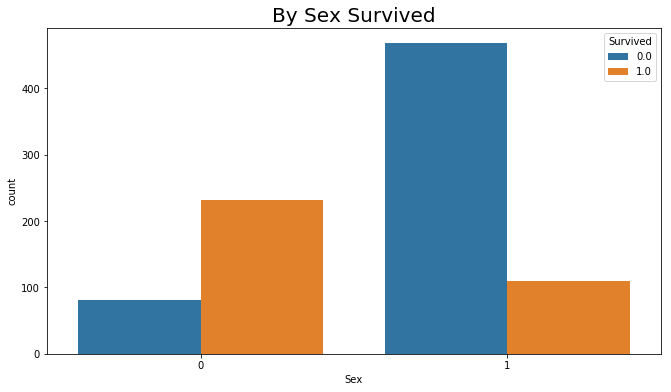

In [11]:
# A string coorelation can be observed 
fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Sex'],hue=full['Survived'])
ax.set_title('By Sex Survived',fontsize = 20)

#### Fare Histograme (Before applyng rang on it )

Text(0.5,1,'By Fare Survived')

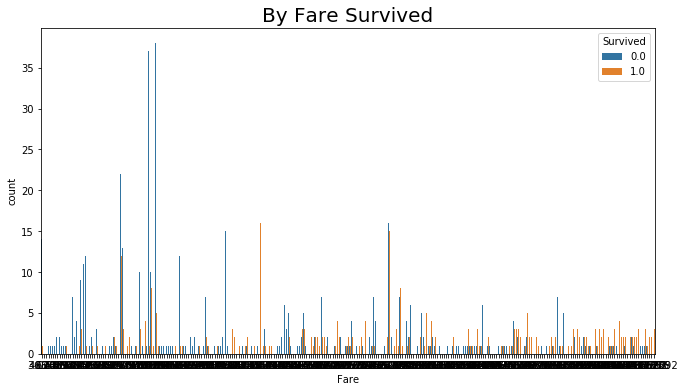

In [12]:

fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Fare'],hue=full['Survived'])
ax.set_title('By Fare Survived',fontsize = 20)


## Transforming Fare to categorical 

In [13]:
fare_ranges = np.array([x*20 for x in range(30)])
full['Fare'] =fare_ranges.searchsorted(full.Fare)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,2
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,2
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,2
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1


#### Fare Histograme (After applyng rang on it )

Text(0.5,1,'By Fare Survived')

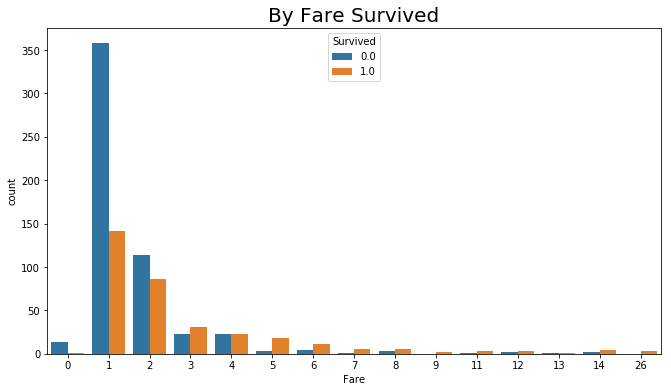

In [14]:

fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Fare'],hue=full['Survived'])
ax.set_title('By Fare Survived',fontsize = 20)

Text(0.5,1,'Passenger has age')

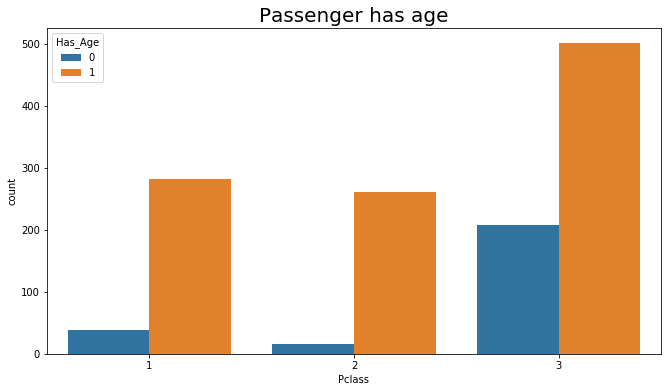

In [15]:
full['Has_Age'] = full['Age'].isnull().map(lambda x : 0 if x == True else 1)
fig = plt.figure(figsize=(11,6))
ax = sns.countplot(full['Pclass'],hue=full['Has_Age'])
ax.set_title('Passenger has age',fontsize = 20)


#### try extract age from name 

In [16]:
# extracted title using name
full['Title'] = full.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize,Has_Age,Title
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,2,1,Mr
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,2,1,Mrs
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,1,Miss
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,2,1,Mrs
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,1,Mr


Text(0.5,0.98,'Age vs Pclass cross Title')

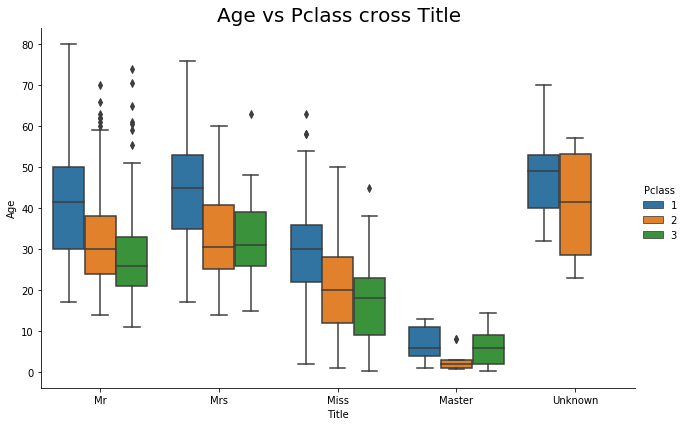

In [17]:
full['Title'] = full['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Unknown') 
full['Title'] = full['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
full['Title'] = full['Title'].replace(['Lady'],'Mrs')
g = sns.factorplot(y='Age',x='Title',kind='box',hue='Pclass', data=full, 
               size=6,aspect=1.5)
plt.subplots_adjust(top=0.93)
g.fig.suptitle('Age vs Pclass cross Title', fontsize = 20)


In [18]:
full.tail()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize,Has_Age,Title
413,NaN,0,1,"Spector, Mr. Woolf",0,3,1,0,NaN,1,0,Mr
414,39.0,1,6,"Oliva y Ocana, Dona. Fermina",0,1,0,0,NaN,1,1,Unknown
415,38.5,0,1,"Saether, Mr. Simon Sivertsen",0,3,1,0,NaN,1,1,Mr
416,NaN,0,1,"Ware, Mr. Frederick",0,3,1,0,NaN,1,0,Mr
417,NaN,1,2,"Peter, Master. Michael J",1,3,1,1,NaN,3,0,Master


### Is family size important ?

In [19]:
data=full[full['Survived'].isnull()==False]
print(data[['FamilySize', 'Survived']].groupby(data['FamilySize'], as_index=False).mean())


   FamilySize  Survived
0           1  0.300935
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


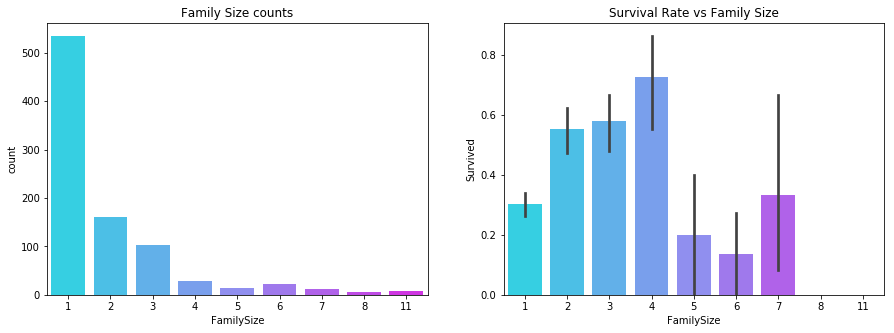

In [20]:
fx, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Family Size counts')
axes[1].set_title('Survival Rate vs Family Size')
fig1_family = sns.countplot(x=data.FamilySize, ax=axes[0], palette='cool')
fig2_family = sns.barplot(x=data.FamilySize, y=data.Survived, ax=axes[1], palette='cool')

most of the passenger are alone but max survival are with 4 as family size

#### Add is alone feature 

In [21]:
full['isAlone'] = full['FamilySize'].map(lambda x: 1 if x<2 or x>7   else 0)


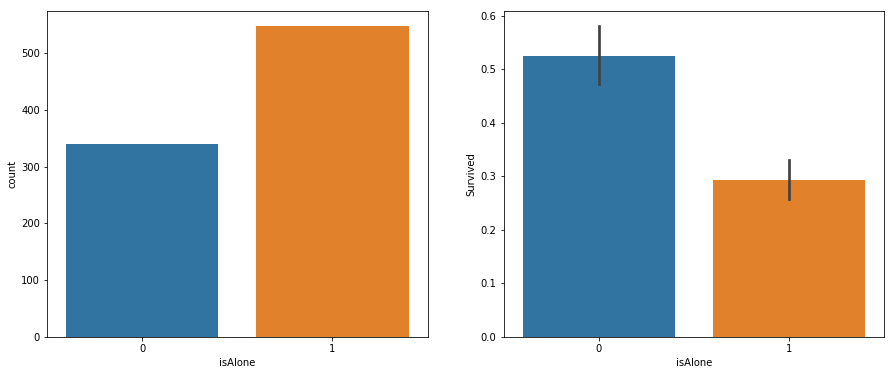

In [22]:
data=full[full['Survived'].isnull()==False]
fx, axes = plt.subplots(1, 2, figsize=(15, 6))
fig1_alone = sns.countplot(data=data, x='isAlone', ax=axes[0])
fig2_alone = sns.barplot(data=data, x='isAlone', y='Survived', ax=axes[1])


In [23]:
## no need for sibsp and parch now 

In [24]:
#full.drop(labels=['SibSp', 'Parch'], axis=1, inplace=True)


In [25]:
missing_mask = (full['Has_Age'] == 0)
pd.crosstab(full[missing_mask]['Pclass'],full[missing_mask]['Title'])

Title,Master,Miss,Mr,Mrs,Unknown
Pclass,,,,,
1,0,1,27,10,1
2,0,2,13,1,0
3,8,48,136,16,0


In [26]:
full.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median)

Title,Master,Miss,Mr,Mrs,Unknown
Pclass,,,,,
1,6.0,30.0,41.5,45.0,49.0
2,2.0,20.0,30.0,30.5,41.5
3,6.0,18.0,26.0,31.0,NaN


In [27]:
full['Title'] = full['Title'].map({"Mr":0, "Unknown" : 1, "Master" : 2, "Miss" : 3, "Mrs" : 4 })
Pclass_title_pred = full.pivot_table(values='Age', index=['Pclass'], columns=['Title'],aggfunc=np.median).values
full['P_Ti_Age'] = full['Age']


In [28]:
print(Pclass_title_pred)

[[41.5 49.   6.  30.  45. ]
 [30.  41.5  2.  20.  30.5]
 [26.   nan  6.  18.  31. ]]


In [29]:
# filling Missing age with Pclass & Title
for i in range(0,5):
    # 0,1,2,3,4
    for j in range(1,4):
        # 1,2,3
            full.loc[(full.Age.isnull()) & (full.Pclass == j) & (full.Title == i),'P_Ti_Age'] = Pclass_title_pred[j-1, i]
full['P_Ti_Age'] = full['P_Ti_Age'].astype('int')

# filling Missing age with Title only
'''Ti_pred = full.groupby('Title')['Age'].median().values
full['Ti_Age'] = full['Age']
for i in range(0,5):
 # 0 1 2 3 4
    full.loc[(full.Age.isnull()) & (full.Title == i),'Ti_Age'] = Ti_pred[i]
full['Ti_Age'] = full['Ti_Age'].astype('int')'''


"Ti_pred = full.groupby('Title')['Age'].median().values\nfull['Ti_Age'] = full['Age']\nfor i in range(0,5):\n # 0 1 2 3 4\n    full.loc[(full.Age.isnull()) & (full.Title == i),'Ti_Age'] = Ti_pred[i]\nfull['Ti_Age'] = full['Ti_Age'].astype('int')"

In [30]:
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize,Has_Age,Title,isAlone,P_Ti_Age
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,2,1,0,0,22
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,2,1,4,0,38
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,1,3,1,26
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,2,1,4,0,35
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,1,0,1,35


#### transform Age to ranges

In [31]:
age_ranges = np.array([16,100])
full['Age'] =age_ranges.searchsorted(full.Age)

full['P_Ti_Age'] = age_ranges.searchsorted(full.P_Ti_Age)
#full['Ti_AgeBin'] = age_ranges.searchsorted(full.Ti_Age)
#label = LabelEncoder()
#full['P_Ti_Code'] = label.fit_transform(full['P_Ti_AgeBin'])
#full['Ti_Code'] = label.fit_transform(full['Ti_AgeBin'])
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize,Has_Age,Title,isAlone,P_Ti_Age
0,1,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,2,1,0,0,1
1,1,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,2,1,4,0,1
2,1,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,1,3,1,1
3,1,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,2,1,4,0,1
4,1,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,1,0,1,1


### mean encoding on family size 

In [32]:
for col in ['FamilySize']:
    data[col+'_mean_target']=0
    full[col+'_mean_target']=0
from sklearn.model_selection import StratifiedKFold
(x_tr,y_tr)=(data.values, data['Survived'].values)
skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=123)
for tr_ind,val_ind in skf.split(x_tr, y_tr):
    X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
    for col in ['FamilySize']:
        means=X_val[col].map(X_tr.groupby(col).Survived.mean())
        data[col+'_mean_target'].iloc[val_ind]=means
    #data.iloc[val_ind]=X_val
full['FamilySize_mean_target']=full['FamilySize'].map(data.groupby('FamilySize').FamilySize_mean_target.mean())


In [33]:
data.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,FamilySize,Has_Age,Title,isAlone,FamilySize_mean_target
0,22.0,0,1,"Braund, Mr. Owen Harris",0,3,1,1,0.0,2,1,Mr,0,0.547009
1,38.0,1,4,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,1,1.0,2,1,Mrs,0,0.570093
2,26.0,0,1,"Heikkinen, Miss. Laina",0,3,0,0,1.0,1,1,Miss,1,0.304110
3,35.0,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,1,1.0,2,1,Mrs,0,0.570093
4,35.0,0,1,"Allen, Mr. William Henry",0,3,1,0,0.0,1,1,Mr,1,0.304110


### Catboost 

In [49]:
data_without_old_age=full.drop(columns=['Name','Age','Has_Age','SibSp','Parch','FamilySize_mean_target','Title'])
data_without_old_age.head()

,Embarked,Fare,Pclass,Sex,Survived,FamilySize,isAlone,P_Ti_Age
0,0,1,3,1,0.0,2,0,1
1,1,4,1,0,1.0,2,0,1
2,0,1,3,0,1.0,1,1,1
3,0,3,1,0,1.0,2,0,1
4,0,1,3,1,0.0,1,1,1


#### some preprocessing for linear based model

In [50]:
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]

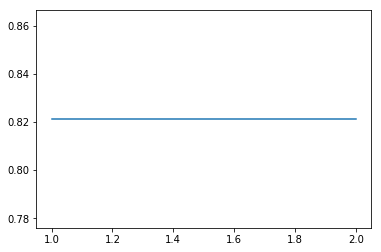

In [51]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


estim=np.array([x for x in range(1,3)])
scores=[]
for n in range(2):
    cat_gbm = CatBoostClassifier (
        random_seed=2,
        logging_level='Silent',
        iterations=20,
        learning_rate=0.05
    )
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        cat_gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(cat_gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    #cv_scores = cross_val_score(gbm, data.drop('Survived',axis=1).values, data['Survived'].values, cv=10)
    scores.append((np.asarray(cv_scores)).mean())
    #print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)




In [57]:
x=data.drop('Survived',axis=1).values
y=data['Survived'].values
#make the x for train and test (also called validation data) 
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=.85,random_state=1234)

cate_features_index = np.where(data.drop('Survived',axis=1).dtypes != float)[0]
cat_boost_prediction=CatBoostClassifier(eval_metric='Accuracy',use_best_model=True,random_seed=42)

#now just to make the model to fit the data
cat_boost_prediction.fit(xtrain,ytrain,cat_features=cate_features_index,eval_set=(xtest,ytest))

Learning rate set to 0.075759
0:	learn: 0.7986755	test: 0.7910448	best: 0.7910448 (0)	total: 17.3ms	remaining: 17.3s
1:	learn: 0.8079470	test: 0.8134328	best: 0.8134328 (1)	total: 36.6ms	remaining: 18.3s
2:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 57.4ms	remaining: 19.1s
3:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 72.3ms	remaining: 18s
4:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 99.3ms	remaining: 19.8s
5:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 114ms	remaining: 19s
6:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 143ms	remaining: 20.2s
7:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 160ms	remaining: 19.8s
8:	learn: 0.8013245	test: 0.7910448	best: 0.8134328 (1)	total: 182ms	remaining: 20.1s
9:	learn: 0.8000000	test: 0.7910448	best: 0.8134328 (1)	total: 202ms	remaining: 20s
10:	learn: 0.7986755	test: 0.7910448	best: 0.8134328 (1)	total: 218ms	remaining: 19.6s
11:	learn: 0.8000000	tes

In [58]:
test['Survived']=cat_boost_prediction.predict(to_predict.drop('Survived',axis=1).values)
cat_boost_prediction=test['Survived']
result_df=test[['PassengerId','Survived']]
result_df['Survived']=result_df['Survived'].astype('int')
result_df.to_csv('output/Catboost.csv',header=True,index=False)
result_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


## XGboosting?

In [141]:
data_without_old_age=full.drop(columns=['Name','Age'])
data_without_old_age.head()

,Embarked,Fare,Pclass,Sex,Survived,FamilySize,Has_Age,Title,isAlone,P_Ti_Age,FamilySize_mean_target
0,0,1,3,1,0.0,2,1,0,0,1,0.552328
1,1,4,1,0,1.0,2,1,4,0,1,0.552328
2,0,1,3,0,1.0,1,1,3,1,1,0.299885
3,0,3,1,0,1.0,2,1,4,0,1,0.552328
4,0,1,3,1,0.0,1,1,0,1,1,0.299885


In [142]:
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]

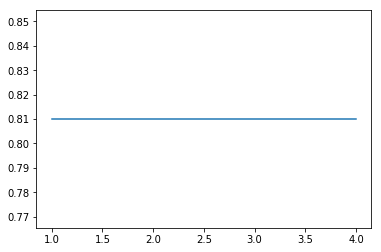

In [143]:
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

estim=np.array([x for x in range(1,5)])
scores=[]
for n in range(4):
    xg_gbm = xgb.XGBClassifier(max_depth=7, n_estimators=15, learning_rate=0.1,colsample_bytree=0.6)
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        xg_gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(xg_gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    scores.append((np.asarray(cv_scores)).mean())
    #print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)


### After fixing the hyper parameter 


In [144]:
to_predict[['Survived']].head()

,Survived
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [145]:
Xgboost_prediction=xg_gbm.predict(to_predict.drop('Survived',axis=1).values)

In [146]:
test['Survived']=rf_gbm.predict(to_predict.drop('Survived',axis=1).values)
result_df=test[['PassengerId','Survived']]
result_df['Survived']=result_df['Survived'].astype('int')
result_df.to_csv('output/XGboost_family_features_eng_and_mean_encoding_again.csv',header=True,index=False)
result_df.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


## Random Forest on the same data 

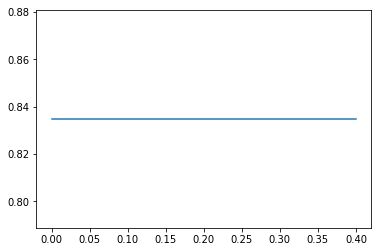

In [147]:
data_without_old_age=full.drop(columns=['Name','Age'])
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]

estim=np.array([0.1*x for x in range(0,5)])
scores=[]
for n in range(5):
    rf_gbm = RandomForestClassifier(max_depth=4, n_estimators=30,min_weight_fraction_leaf=0,random_state=10)
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        rf_gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(rf_gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    #cv_scores = cross_val_score(gbm, data.drop('Survived',axis=1).values, data['Survived'].values, cv=10)
    scores.append((np.asarray(cv_scores)).mean())
    #print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)


In [148]:
Rforest_prediction=rf_gbm.predict(to_predict.drop('Survived',axis=1).values)

In [136]:
test['Survived']=rf_gbm.predict(to_predict.drop('Survived',axis=1).values)
result_df=test[['PassengerId','Survived']]
result_df['Survived']=result_df['Survived'].astype('int')
result_df.to_csv('output/Random_f_output_family_sz_.csv',header=True,index=False)
result_df.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


#### Stacking 

In [149]:
data_without_old_age=full.drop(columns=['Name','Has_Age','Age','FamilySize_mean_target'])
to_predict=data_without_old_age[data_without_old_age['Survived'].isnull()]
data=data_without_old_age[False==data_without_old_age['Survived'].isnull()]

X_train, X_val, y_train, y_val = train_test_split(data.drop(columns=['Survived']).values, data['Survived'].values, test_size=0.5, random_state=42)


In [150]:
rf_gbm.fit(X_train,y_train) # train model 1
xg_gbm.fit(X_train,y_train) # train model 2
cat_gbm.fit(X_train,y_train) # train model 3

In [151]:
pred1=rf_gbm.predict(X_val)
pred2=xg_gbm.predict(X_val)
pred3=cat_gbm.predict(X_val)

In [152]:
test_pred1=rf_gbm.predict(to_predict.drop(columns=['Survived']).values)
test_pred2=xg_gbm.predict(to_predict.drop(columns=['Survived']).values)
test_pred3=cat_gbm.predict(to_predict.drop(columns=['Survived']).values)

In [153]:
stacked_pred=np.column_stack((pred1,pred2,pred3))
stacked_test_pred=np.column_stack((test_pred1,test_pred2,test_pred3))


In [154]:
to_predict.drop(columns=['Survived']).values

array([[2, 1, 3, ..., 0, 1, 1],
       [0, 1, 3, ..., 4, 0, 1],
       [2, 1, 2, ..., 0, 1, 1],
       ...,
       [0, 1, 3, ..., 0, 1, 1],
       [0, 1, 3, ..., 0, 1, 1],
       [1, 2, 3, ..., 2, 0, 0]])

In [155]:
stacked_pred.shape

(445, 3)

In [156]:
meta_model=xgb.XGBClassifier(max_depth=7, n_estimators=15, learning_rate=0.1,colsample_bytree=0.6)
meta_model.fit(stacked_pred,y_val)
final_pred=meta_model.predict(stacked_test_pred)
test['Survived']=final_pred
result_df=test[['PassengerId','Survived']]
result_df['Survived']=result_df['Survived'].astype('int')
result_df.to_csv('output/Stacking_3_models.csv',header=True,index=False)
result_df.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


#### --Extra try --

In [103]:
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 30),
    'max_depth': range(6, 15),
    'min_weight_fraction_leaf': [.0, .1, .2, .3, .4,.5],
}

gbm = RandomForestClassifier(n_estimators=10)
#using hypertuning automatic##
forest_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
forest_random.fit(data.drop('Survived',axis=1).values,data.Survived.values)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", forest_random.best_params_)
print("Best accuracy found: ", forest_random.best_score_)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 14, 'min_weight_fraction_leaf': 0.0, 'max_depth': 8}
Best accuracy found:  0.8211473565804275


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.2s finished


### mean encoding-To be tried

In [33]:
'''for col in ['Sex','Fare']:
    data[col+'_mean_target']=0
    full[col+'_mean_target']=0'''
for col in ['Sex']:
    data[col+'_mean_target']=0
    full[col+'_mean_target']=0

In [102]:
data.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,P_Ti_Age
0,0,1,0,3,1,1,0.0,0,1
1,1,1,0,1,0,1,1.0,4,1
2,0,1,0,3,0,0,1.0,3,1
3,0,1,0,1,0,1,1.0,4,1
4,0,1,0,3,1,0,0.0,0,1


### Adding mean feature values by sex 

In [35]:
from sklearn.model_selection import StratifiedKFold
(x_tr,y_tr)=(data.values, data['Survived'].values)
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
for tr_ind,val_ind in skf.split(x_tr, y_tr):
    X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
    for col in ['Sex']:
        means=X_val[col].map(X_tr.groupby(col).Survived.mean())
        data[col+'_mean_target'].iloc[val_ind]=means
    #data.iloc[val_ind]=X_val
    
    
    

In [36]:
data.head()

,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title,P_Ti_Age,Sex_mean_target
0,0,1,0,3,1,1,0.0,0,1,0.188825
1,1,4,0,1,0,1,1.0,4,1,0.743682
2,0,1,0,3,0,0,1.0,3,1,0.743682
3,0,3,0,1,0,1,1.0,4,1,0.732143
4,0,1,0,3,1,0,0.0,0,1,0.191205


In [40]:
for col in ['Sex']:
    full['Sex_mean_target']=full['Sex'].map(data.groupby('Sex').Sex_mean_target.mean())


In [556]:
full.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Sex_mean_target
0,22.0,0,7.2500,0,3,1,1,0.0,0.188830
1,38.0,1,71.2833,0,1,0,1,1.0,0.740675
2,26.0,0,7.9250,0,3,0,0,1.0,0.740675
3,35.0,0,53.1000,0,1,0,1,1.0,0.740675
4,35.0,0,8.0500,0,3,1,0,0.0,0.188830


In [21]:
to_predict=full[full['Survived'].isnull()]

In [23]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

gbm = xgb.XGBClassifier(n_estimators=10)
#using hypertuning automatic##
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(data.drop('Survived',axis=1).values,data.Survived.values)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'n_estimators': 8, 'max_depth': 6, 'learning_rate': 0.55, 'colsample_bytree': 0.7}
Best accuracy found:  0.8008998875140607


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.3s finished


0.8087972420837589
0.80658835546476
0.8032175689479061
0.8076864147088866
0.7986721144024514
0.793041368743616
0.7874361593462716
0.8009065372829417


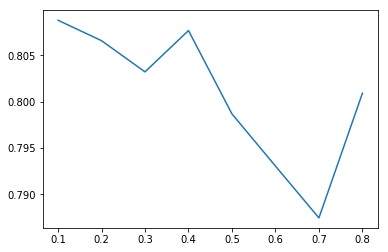

In [31]:
import warnings
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

estim=np.array([0.1*x for x in range(1,9)])
scores=[]
for n in range(8):
    gbm = xgb.XGBClassifier(max_depth=6, n_estimators=8, learning_rate=estim[n],colsample_bytree=0.7)
    (x_tr,y_tr)=(data.drop('Survived',axis=1).values, data['Survived'].values)
    skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
    cv_scores=[]
    for tr_ind,val_ind in skf.split(x_tr, y_tr):
        X_tr, X_val=data.iloc[tr_ind],data.iloc[val_ind]
        gbm.fit(data.iloc[tr_ind].drop('Survived',axis=1).values,data.iloc[tr_ind].Survived.values)
        cv_scores.append(accuracy_score(gbm.predict(data.iloc[val_ind].drop('Survived',axis=1).values),data.iloc[val_ind].Survived.values))

    #cv_scores = cross_val_score(gbm, data.drop('Survived',axis=1).values, data['Survived'].values, cv=10)
    scores.append((np.asarray(cv_scores)).mean())
    print((np.asarray(cv_scores)).mean())
plt.plot(estim,scores)


In [28]:
gbm = xgb.XGBClassifier(max_depth=6, n_estimators=8, learning_rate=0.55,colsample_bytree=0.7)
gbm.fit(data.drop('Survived',axis=1).values, data['Survived'].values)

res=xgb_random.predict(to_predict.drop(columns=['Survived']).values)

In [25]:
res_df=pd.DataFrame(columns=['PassengerId','Survived'],data=test['PassengerId'])

In [26]:
res_df['Survived']=res
res_df['Survived']=res_df['Survived'].apply(lambda  x :1 if x>0.1 else 0)
res_df.to_csv('output/XGboost.csv',header=True,index=False)

In [ ]:
res_df.head()